<a href="https://colab.research.google.com/github/RishitSingh10/SkimLit/blob/main/project_2_skimlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Description:

The purpose of this project is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here: https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they used to achieve the best results is available here: https://arxiv.org/abs/1612.05251

In [1]:
import tensorflow as tf
import numpy as np

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 34.51 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# dev.txt is same as validation set

# Starting experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + '/' + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Exploring the text data through visualisation.

In [6]:
# reading in all the lines of a target text file
file = open(data_dir + '/train.txt' , 'r')
train_text_list = file.readlines()

In [7]:
print(train_text_list[:10][1])

OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .



In [8]:
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath

  Returns:
    A list of strings with one string per line from the target from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [9]:
# Let's read in the training lines
train_lines = get_lines(data_dir + '/train.txt') # read the lines within the training file
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [10]:
len(train_lines)

210040

In [11]:
train_lines[1:20]

['OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C

Our data would be best represented as:
```
[{'line_number' : 0,
  'target' : 'BACKGROUND',
  'text' : "Emotional eating is associated with overeating and the development of obesity .\n"
  'total_lines' : 11},
  ...]
```
Writing a function to turn our data into the above format

In [12]:
def preprocess(filename):

  lines = get_lines(filename)

  abstract_lines = ""
  abstract_samples = []

  for line in lines:

    if line.startswith("###"):
      abstract_ID = line
      abstract_lines = ""

    elif line.isspace(): # new abstract found

      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):

        line_data = {}
        target_line_split = abstract_line.split('\t')

        line_data['line_number'] = abstract_line_number
        line_data['label'] = target_line_split[0]
        line_data['text'] = target_line_split[1]
        line_data['total_lines'] = len(abstract_line_split)-1
        abstract_samples.append(line_data)

    else:
      abstract_lines+=line

  return abstract_samples

In [13]:
# Get data from the file and preprocess it
%%time
train_samples = preprocess(data_dir + "/train.txt")
val_samples = preprocess(data_dir + "/dev.txt") # dev is another name for valid
test_samples = preprocess(data_dir + "/test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 342 ms, sys: 79.9 ms, total: 422 ms
Wall time: 434 ms


In [14]:
# Check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'label': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'label': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'label': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'label': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'label': 'METHODS',
  'text': 'Secondary outcome measures included the

Turning the list of dictionaries into a DataFrame

In [15]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,line_number,label,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
5,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,6,RESULTS,There was a clinically relevant reduction in t...,11
7,7,RESULTS,The mean difference between treatment arms ( @...,11
8,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,9,RESULTS,These differences remained significant at @ we...,11


## Visualizing Data

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='Number of sentences', ylabel='label'>

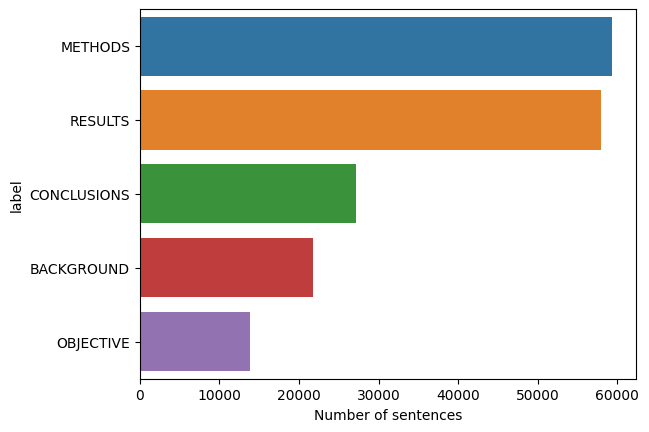

In [17]:
# Distribution of labels in training data
df = pd.DataFrame(train_df['label'].value_counts())
df.reset_index(inplace=True)
# sns.barplot(x = df['Number of sentences'], y = df['index'])
df.columns = ['label', 'Number of sentences']
sns.barplot(x = df['Number of sentences'], y = df['label'])

Text(0.5, 0, 'Number of sentences per abstract')

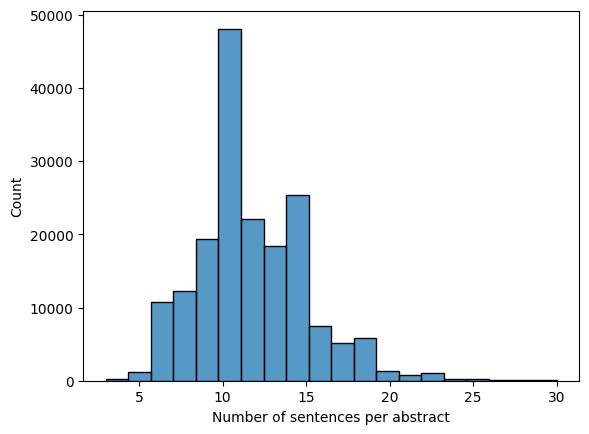

In [18]:
# Distribution of number of sentences per abstract
sns.histplot(train_df['total_lines'], bins=20 )
plt.xlabel('Number of sentences per abstract')

## Get lists of sentences

In [19]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [20]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

Text(0.5, 0, 'Number of tokens per sentence')

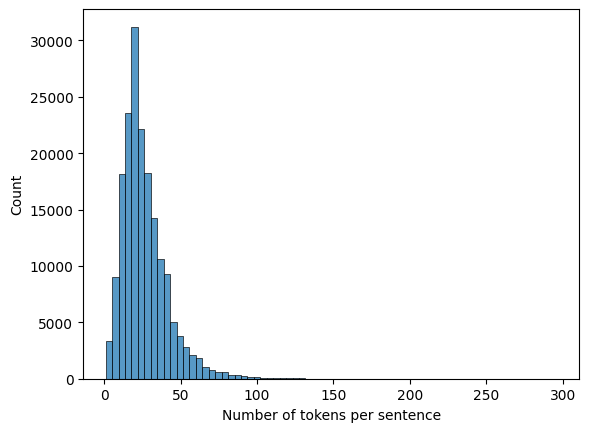

In [21]:
# Distribution of number of tokens per sentence
num_tokens = []
for sentence in train_sentences:
  tokens = sentence.split()
  num_tokens.append(len(tokens))

sns.histplot(num_tokens, bins=70)
plt.xlabel('Number of tokens per sentence')

## Make numeric labels

In [22]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output = False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['label'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['label'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['label'].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
# Label encode labels : encoding labels as integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['label'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['label'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['label'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(train_sentences)

model_0 = MultinomialNB()

model_0.fit(X_train, train_labels_encoded)

MultinomialNB()

In [26]:
X_val = tfidf.transform(val_sentences)
y_pred = model_0.predict(X_val)

confusion_matrix(val_labels_encoded, y_pred)

array([[1683,  794,  694,   97,  181],
       [ 244, 2687,  432,    5, 1214],
       [ 116,   75, 8670,    7, 1096],
       [ 505,  422,  978,  325,  146],
       [  20,  181, 1196,    1, 8443]])

In [27]:
model_0.score(X_val, val_labels_encoded)

0.7218323844829869

In [28]:
!wget https://raw.githubusercontent.com/RishitSingh10/Multiclass-Image-Classification/main/helper_functions.py

--2023-10-24 06:47:25--  https://raw.githubusercontent.com/RishitSingh10/Multiclass-Image-Classification/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11043 (11K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.78K  --.-KB/s    in 0s      

2023-10-24 06:47:26 (71.7 MB/s) - ‘helper_functions.py’ saved [11043/11043]



In [29]:
# Calculate baseline results
from helper_functions import print_evaluation_metrics
baseline_results = print_evaluation_metrics(y_pred,val_labels_encoded)

Confusion matrix:  [[1683  794  694   97  181]
 [ 244 2687  432    5 1214]
 [ 116   75 8670    7 1096]
 [ 505  422  978  325  146]
 [  20  181 1196    1 8443]]


In [30]:
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.646068766530416,
 'recall': 0.58642514185945,
 'f1-score': 0.6148037981924266}

## Tokenization

In [31]:
# Average number of tokens in each training sentence
import tensorflow as tf
tf.round(sum(num_tokens)/len(train_sentences))

<tf.Tensor: shape=(), dtype=float32, numpy=26.0>

In [32]:
# How long of sentence length covers 95% of examples
np.percentile(num_tokens, 95)

55.0

In [33]:
# Maximum sequence length in the training set
max(num_tokens)

296

In [34]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 68000 # maximum number of words to have in our vocabulary (taken from table 2 of the paper)
max_length = 55 # max length of the sequence (how many words our model would see at time from a sequence)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_sequence_length = max_length,
                                    output_mode = 'int')

In [35]:
# Adapt text vectorizer on random sentences
text_vectorizer.adapt(train_sentences)

In [36]:
sample_sentence = "Research paper implementation using deep learning"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 285, 1716,  754,   59, 1676,  953,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [37]:
# Testing out text vectorizer on random sentences
import random

random_sentence = random.choice(train_sentences)
print("Text:\n", random_sentence)
print("\nLength of text:\n", len(random_sentence.split()))
print("\nTokens:\n", text_vectorizer([random_sentence]))

Text:
 Most courses rely on the lecture although it may bring less benefit to students .

Length of text:
 15

Tokens:
 tf.Tensor(
[[ 215 2539 8820   18    2 7345  311  185   91 8509  211  398    6  515
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)


In [38]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print("Number of words in vocab: ", len(text_vectorizer.get_vocabulary()))
print("\nMost common words: ", rct_20k_text_vocab[:5])
print("\nLeast common words: ", rct_20k_text_vocab[-5:])

Number of words in vocab:  64841

Most common words:  ['', '[UNK]', 'the', 'and', 'of']

Least common words:  ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


## Creating an embedding using Embedding layer

In [39]:
embedding = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                      output_dim = 128,
                                      mask_zero = True, # save space
                                      input_length = max_length,
                                      name="token_embedding")

embedding(text_vectorizer([sample_sentence]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[ 0.03373729,  0.01230728, -0.01307064, ...,  0.03068532,
         -0.04262669, -0.01968951],
        [-0.01087145, -0.01217536,  0.03350702, ...,  0.0313018 ,
         -0.0027251 ,  0.03973024],
        [-0.04225263, -0.01485284, -0.00584299, ...,  0.017673  ,
         -0.00319453, -0.00948245],
        ...,
        [-0.04491195,  0.01542772,  0.03081838, ...,  0.0375082 ,
         -0.02583917,  0.0065609 ],
        [-0.04491195,  0.01542772,  0.03081838, ...,  0.0375082 ,
         -0.02583917,  0.0065609 ],
        [-0.04491195,  0.01542772,  0.03081838, ...,  0.0375082 ,
         -0.02583917,  0.0065609 ]]], dtype=float32)>

## Creating datasets (making sure our data loads as fast as possible)
Setting up our data to run as fast as possible with the TensorFlow tf.data API.

In [40]:
# Turn our data into TensorFLow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model_1: Conv1D

In [42]:
# Creating a Sequential model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1,), dtype = tf.string),
    text_vectorizer,
    embedding,
    tf.keras.layers.Conv1D(32, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

# Compiling the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# fit the model
history_1 = model_1.fit(train_dataset,
                        epochs = 3,
                        validation_data = valid_dataset,
                        validation_steps = int(0.15*(len(val_sentences))))

Epoch 1/3
5627/5627 [==============================] - ETA: 0s - loss: 0.6415 - accuracy: 0.7656

5627/5627 [==============================] - 72s 11ms/step - loss: 0.6415 - accuracy: 0.7656 - val_loss: 0.5421 - val_accuracy: 0.8074
Epoch 2/3
5627/5627 [==============================] - 36s 6ms/step - loss: 0.4635 - accuracy: 0.8379
Epoch 3/3
5627/5627 [==============================] - 36s 6ms/step - loss: 0.3842 - accuracy: 0.8681


In [43]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 51, 32)            20512     
                                                                 
 global_average_pooling1d (  (None, 32)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 5)                 165       
                                                        

In [44]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.5591 - accuracy: 0.8064


[0.5591077208518982, 0.8064014315605164]

In [45]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[7.7073365e-01, 2.0114049e-02, 8.5099578e-02, 8.4687933e-02,
         3.9364774e-02],
        [6.1086953e-01, 1.3623230e-01, 1.1207474e-02, 2.1601881e-01,
         2.5671922e-02],
        [9.9186532e-02, 1.9101237e-03, 2.6734482e-04, 8.9863282e-01,
         3.1476295e-06],
        ...,
        [8.1308400e-08, 3.2832177e-06, 1.7976016e-03, 3.2874837e-07,
         9.9819869e-01],
        [5.6553215e-02, 5.5956352e-01, 1.6574192e-01, 9.0523586e-03,
         2.0908892e-01],
        [8.0885421e-03, 9.8766994e-01, 3.4614310e-03, 2.3574761e-05,
         7.5642217e-04]], dtype=float32),
 (30212, 5))

In [46]:
# Convert pred probs to classes
model_1_preds = model_1_pred_probs.argmax(axis=1)
model_1_preds

array([0, 0, 3, ..., 4, 1, 1])

In [47]:
# Calculate model_1 results
model_1_results = print_evaluation_metrics(val_labels_encoded,
                                           model_1_preds)

Confusion matrix:  [[2232  386  127  716   46]
 [ 487 3307   90  201  369]
 [ 256  156 8821  175  656]
 [ 396   58   66 1246   13]
 [  78  675  860   38 8757]]


In [48]:
model_1_results

{'accuracy': 0.8064014298954058,
 'precision': 0.7217372326494981,
 'recall': 0.7424786708576561,
 'f1-score': 0.7319610447100487}

In [49]:
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.646068766530416,
 'recall': 0.58642514185945,
 'f1-score': 0.6148037981924266}

## Model 2: Feature extraction with pretrained token embeddings
Using pretrained word embeddings from TensorFlow Hub, Universal Sentence Encoder (USE)

In [50]:
# Download pretrained TnesorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [51]:
# Testing out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 As an additional sensitivity analysis , we also analysed the primary endpoint on the per-protocol population .
Sentence after embedding:
[ 0.02714292  0.05567386 -0.05949141 -0.00734102  0.05293018 -0.05710895
 -0.04678936 -0.07009881  0.08220278  0.05437427  0.03187843 -0.01958769
 -0.011081    0.01611153 -0.0690648  -0.0055255   0.06075109 -0.03611505
  0.07475819  0.04413417 -0.09031126  0.03940066 -0.05516799  0.02875543
  0.06647654  0.01652138 -0.07134716 -0.003206    0.06384683  0.02150534]

Length of sentence embedding: 512


In [52]:
from keras.src.layers import GlobalAveragePooling1D
# Creating model 2
model_2 = tf.keras.Sequential([
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(5, activation = 'softmax')
])

# Compiling the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [53]:
# Fitting the model
hsitory_2 = model_2.fit(train_dataset,
            epochs = 3,
            validation_data = valid_dataset,
            validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
5627/5627 [==============================] - 76s 13ms/step - loss: 0.9030 - accuracy: 0.6643 - val_loss: 0.7975 - val_accuracy: 0.6975
Epoch 2/3
5627/5627 [==============================] - 75s 13ms/step - loss: 0.7868 - accuracy: 0.7003 - val_loss: 0.7740 - val_accuracy: 0.7048
Epoch 3/3
5627/5627 [==============================] - 75s 13ms/step - loss: 0.7721 - accuracy: 0.7054 - val_loss: 0.7648 - val_accuracy: 0.7091


In [54]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.7623 - accuracy: 0.7093


[0.7623076438903809, 0.7093207836151123]

In [55]:
# Evaluating the model
model_2_pred_probs = model_2.predict(valid_dataset)


945/945 [==============================] - 12s 12ms/step


In [56]:
model_2_preds = model_2_pred_probs.argmax(axis=1)
model_2_preds

array([0, 1, 3, ..., 4, 4, 2])

In [57]:
model_2_results = print_evaluation_metrics(model_2_preds, val_labels_encoded)
model_2_results

Confusion matrix:  [[1840  706  399  359  145]
 [ 661 2576  424  141  780]
 [ 285  199 8094  110 1276]
 [ 522  327  352 1073  102]
 [  94  397 1481   22 7847]]


{'accuracy': 0.7093207996822455,
 'precision': 0.6126040428061831,
 'recall': 0.5621999127018769,
 'f1-score': 0.5863207010356207}

In [58]:
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.646068766530416,
 'recall': 0.58642514185945,
 'f1-score': 0.6148037981924266}

## Model 3: Conv1D with character embeddings

The paper states they used a combination of token and character-level embedding

### Creating a character-level tokenizer

In [59]:
# Function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random_train_sentence)

'A s   a n   a d d i t i o n a l   s e n s i t i v i t y   a n a l y s i s   ,   w e   a l s o   a n a l y s e d   t h e   p r i m a r y   e n d p o i n t   o n   t h e   p e r - p r o t o c o l   p o p u l a t i o n   .'

In [60]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [61]:
# What's the average character length
num_chars = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(num_chars)
mean_char_len

149.3662574983337

<Axes: ylabel='Count'>

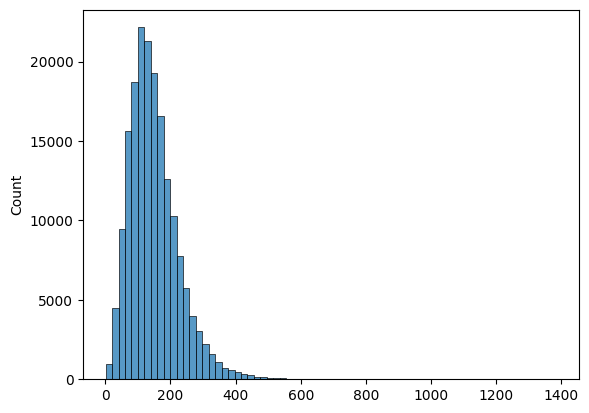

In [62]:
sns.histplot(num_chars, bins = 70)

In [63]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(num_chars, 95))
output_seq_char_len

290

In [64]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [65]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '{UNK}')
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                      output_sequence_length = output_seq_char_len,
                                      name = "char_vectorizer")

In [66]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [67]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different charcaters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different charcaters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [68]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 C l i n i c a l   i m p l i c a t i o n s   T r e a t m e n t   f a i l u r e   i s   a s s o c i a t e d   w i t h   a   l o w e r   t h e r a p e u t i c   a l l i a n c e   i n   c o g n i t i v e - b e h a v i o u r a l   t r e a t m e n t   .
Length of random_train_chars: 110
Vectorized chars:
 [[11 12  4  6  4 11  5 12  4 15 14 12  4 11  5  3  4  7  6  9  3  8  2  5
   3 15  2  6  3 17  5  4 12 16  8  2  4  9  5  9  9  7 11  4  5  3  2 10
  20  4  3 13  5 12  7 20  2  8  3 13  2  8  5 14  2 16  3  4 11  5 12 12
   4  5  6 11  2  4  6 11  7 18  6  4  3  4 21  2 22  2 13  5 21  4  7 16
   8  5 12  3  8  2  5  3 15  2  6  3  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0

### Creating a character-level embedding

In [69]:
# Creating char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab), # number of different characters
                                       output_dim = 25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (figure 1)
                                       mask_zero = True,
                                       name = 'char_embed')

In [70]:
# Test our character embedding layer
print(f"Charified text:\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars. (after vectorization and embedding):\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
C l i n i c a l   i m p l i c a t i o n s   T r e a t m e n t   f a i l u r e   i s   a s s o c i a t e d   w i t h   a   l o w e r   t h e r a p e u t i c   a l l i a n c e   i n   c o g n i t i v e - b e h a v i o u r a l   t r e a t m e n t   .

Embedded chars. (after vectorization and embedding):
 [[[ 0.00667288  0.04355862 -0.0144271  ... -0.00082918 -0.03425677
   -0.02014796]
  [ 0.00833816 -0.01645859  0.01252072 ... -0.04568462 -0.04028901
    0.01228849]
  [-0.04050864  0.00088483 -0.00289302 ... -0.00877225 -0.0283734
    0.03124538]
  ...
  [ 0.03626195  0.01011728  0.03254007 ... -0.03133889  0.01609324
   -0.04021502]
  [ 0.03626195  0.01011728  0.03254007 ... -0.03133889  0.01609324
   -0.04021502]
  [ 0.03626195  0.01011728  0.03254007 ... -0.03133889  0.01609324
   -0.04021502]]]
Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings


In [71]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (1,), dtype = tf.string ),
    char_vectorizer,
    char_embed,
    tf.keras.layers.Conv1D(64, 5,padding = 'same', activation = 'relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(5, activation = 'softmax')
])

model_3.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [72]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 9089 (35.50 KB)
Trainable params: 9089 (

In [73]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [74]:
# fit the model
history_3 = model_3.fit(train_char_dataset,
                        epochs = 3,
                        validation_data = val_char_dataset,
                        validation_steps = int(.1*len(valid_dataset)))

Epoch 1/3
5627/5627 [==============================] - 34s 6ms/step - loss: 0.8992 - accuracy: 0.6482 - val_loss: 0.7734 - val_accuracy: 0.7078
Epoch 2/3
5627/5627 [==============================] - 33s 6ms/step - loss: 0.7547 - accuracy: 0.7113 - val_loss: 0.7366 - val_accuracy: 0.7224
Epoch 3/3
5627/5627 [==============================] - 32s 6ms/step - loss: 0.7186 - accuracy: 0.7273 - val_loss: 0.7124 - val_accuracy: 0.7317


In [75]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 4s 5ms/step - loss: 0.7205 - accuracy: 0.7305


[0.720499575138092, 0.7304713129997253]

In [76]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 4s 4ms/step


array([[0.4884421 , 0.1672269 , 0.04391814, 0.25779524, 0.04261767],
       [0.2785235 , 0.6702131 , 0.0034038 , 0.03700447, 0.01085507],
       [0.33496484, 0.02404939, 0.01302709, 0.6257877 , 0.00217098],
       ...,
       [0.00192552, 0.00583512, 0.01985298, 0.00220427, 0.9701821 ],
       [0.00621537, 0.08798435, 0.03645608, 0.00731528, 0.86202896],
       [0.05810906, 0.8912997 , 0.03262545, 0.00874696, 0.00921882]],
      dtype=float32)

In [77]:
model_3_preds = model_3_pred_probs.argmax(axis=1)
model_3_preds

array([0, 1, 3, ..., 4, 4, 1])

In [78]:
model_3_results = print_evaluation_metrics(model_3_preds,
                                           val_labels_encoded)
model_3_results

Confusion matrix:  [[1890  662  324  314  259]
 [ 610 2541  235   57 1139]
 [ 188  151 7959   73 1593]
 [ 682  318  245  965  166]
 [  78  282  762    5 8714]]


{'accuracy': 0.7304713358930226,
 'precision': 0.6426403641881638,
 'recall': 0.554561326931471,
 'f1-score': 0.595360824742268}

In [79]:
baseline_results

{'accuracy': 0.7218323844829869,
 'precision': 0.646068766530416,
 'recall': 0.58642514185945,
 'f1-score': 0.6148037981924266}

## Model 4: Combining pretrained token embeddings +  characters embeddings (hybrid embedding layer)

1. Create a token level embedding model (similar `model_1`)
2. Create a character level embedding model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate (`layers.concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [80]:
# 1. Setup token inputs/model
token_inputs = tf.keras.layers.Input(shape = [], dtype = tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Setup char inputs/model
char_inputs = tf.keras.layers.Input(shape=(1,), dtype = tf.string, name = 'char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create a hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                             char_model.output])


# 4. Create output layers - adding in Dropout, discussed in section 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation = 'softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_char_embeddings')

In [81]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['

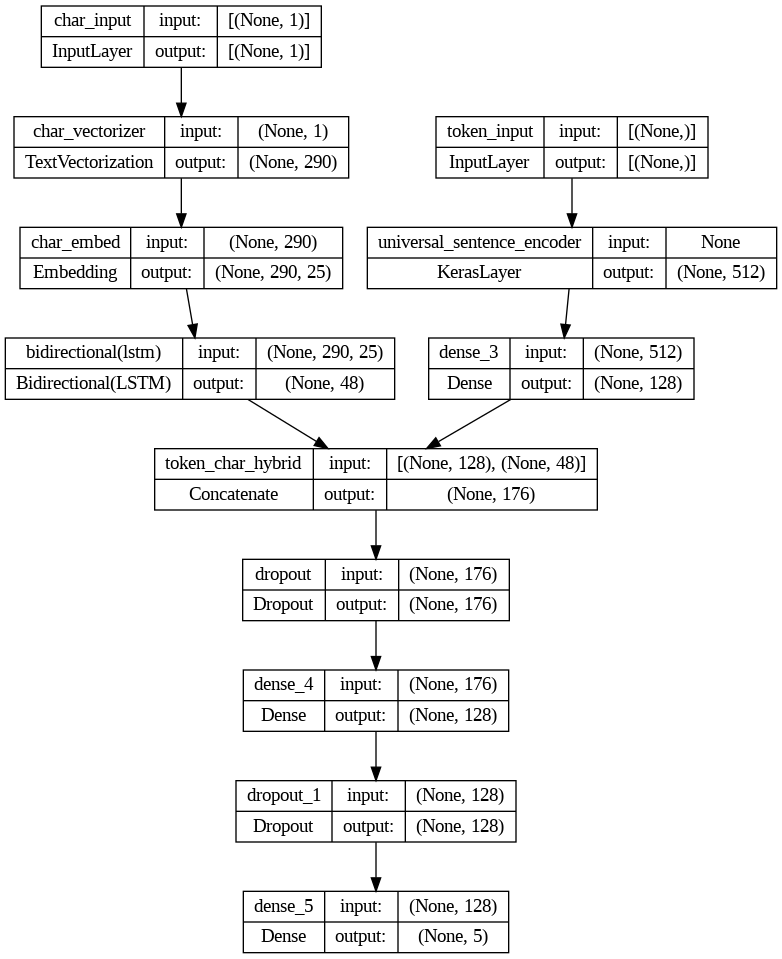

In [82]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes = True)

In [83]:
# Compile token char model
model_4.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

### Combining token and character data into a tf.data Dataset

In [84]:
# Combine chars and tokens into dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeating the above steps for validation data

# Combine chars and tokens into dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [85]:
# Check our training dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [86]:
# Fitting model_4 (hybrid model)
history_4 = model_4.fit(train_char_token_dataset,
                        epochs = 3,
                        validation_data = val_char_token_dataset,
                        validation_steps = int(.1*len(val_char_token_dataset)))

Epoch 1/3
5627/5627 [==============================] - 286s 49ms/step - loss: 0.7565 - accuracy: 0.7122 - val_loss: 0.6161 - val_accuracy: 0.7689
Epoch 2/3
5627/5627 [==============================] - 267s 48ms/step - loss: 0.6735 - accuracy: 0.7470 - val_loss: 0.5943 - val_accuracy: 0.7829
Epoch 3/3
5627/5627 [==============================] - 290s 52ms/step - loss: 0.6484 - accuracy: 0.7568 - val_loss: 0.5765 - val_accuracy: 0.7856


In [87]:
# Evaluating the model on whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.5776 - accuracy: 0.7806


[0.5776237845420837, 0.7805507779121399]

In [88]:
# Making predictions
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_preds = model_4_pred_probs.argmax(axis = 1)

model_4_results = print_evaluation_metrics(model_4_preds, val_labels_encoded)

945/945 [==============================] - 22s 20ms/step
Confusion matrix:  [[2155  642  291  244  117]
 [ 474 2991  251    7  859]
 [ 141  136 8772   44  871]
 [ 751  248  201 1125   51]
 [  50  271  979    2 8539]]


In [89]:
model_4_results

{'accuracy': 0.7805507745266781,
 'precision': 0.6975279850746269,
 'recall': 0.6527717154081187,
 'f1-score': 0.6744081172491544}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings


In [90]:
train_df.head()

,line_number,label,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


> **Note:** Any engineered features used to train a model needs to be available at test time. In our case, line numbers and total lines are available

### Create positional embeddings

In [92]:
# How many different line numbers are there
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

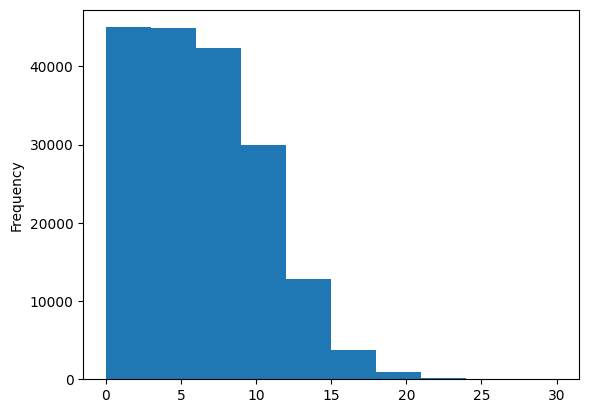

In [93]:
# Check distribution of line number df
train_df.line_number.plot.hist()

In [95]:
# Use TensorFlow to create one-hot-encoded tensors of out "line_number" column
train_line_number_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth = 15)
val_line_number_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth = 15)
test_line_number_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth = 15)
train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [97]:
# How many different total lines are there
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

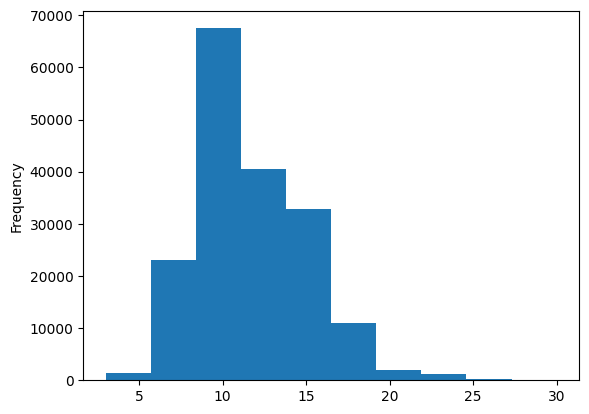

In [98]:
# Check distribution of total lines df
train_df['total_lines'].plot.hist()

In [100]:
# Check the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [102]:
# Creating one-hot encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth = 20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth = 20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth = 20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1,2,3,4 and outputs of 7 into tf.keras.Model

In [106]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs)

# 2. Character inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype = tf.string, name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Line Number inputs
line_number_inputs = tf.keras.layers.Input(shape = (15,), dtype = tf.float32, name = 'line_number_inputs')
line_number_outputs = tf.keras.layers.Dense(32, activation = 'relu')(line_number_inputs)
line_number_model = tf.keras.Model(inputs = line_number_inputs,
                                   outputs = line_number_outputs)

# 4. Total lines inputs
total_lines_inputs = tf.keras.layers.Input(shape = (20,), dtype = tf.float32, name = 'total_lines_inputs')
total_lines_outputs = tf.keras.layers.Dense(32, activation = 'relu')(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs = total_lines_inputs,
                                   outputs = total_lines_outputs)

# 5. Combine token and char embeddings into a hybrid embeddings
combined_embeddings = tf.keras.layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output,
                                                                                         char_model.output])
# 6. Adding a dropout layer as mentioned in the paper
combined_dropout = tf.keras.layers.Dropout(0.5)(combined_embeddings)
combined_dense = tf.keras.layers.Dense(128, activation = 'relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)

# 7. Combine positional embeddings with combined token and char embeddings
tribrid_embeddings = tf.keras.layers.Concatenate(name = 'char_token_positional_embedding')([line_number_model.output,
                                                                                            total_lines_model.output,
                                                                                            final_dropout])

# 8. Create output layer
output_layer = tf.keras.layers.Dense(5, activation = 'softmax', name = 'output_layer')(tribrid_embeddings)

# 9. Put together model with all kind of inputs
model_5 = tf.keras.Model(inputs = [line_number_model.input,
                                   total_lines_model.input,
                                   token_model.input,
                                   char_model.input],
                         outputs = output_layer)

In [108]:
model_5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_inputs[0][0]'] 

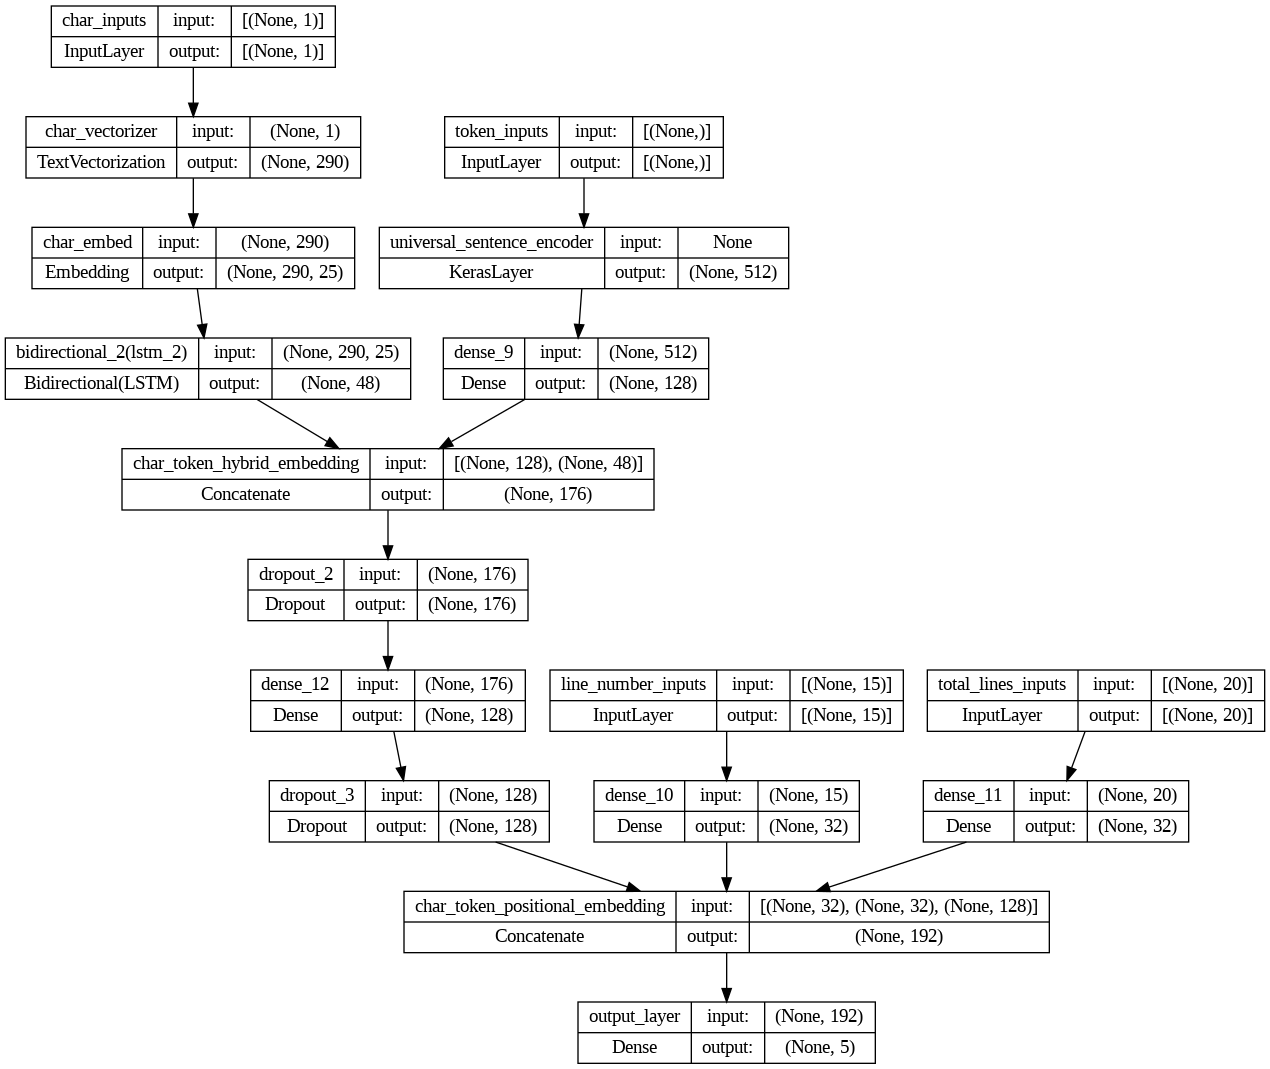

In [111]:
# Exploring model_5 visually
from tensorflow.keras.utils import plot_model

plot_model(model_5, show_shapes = True)

What is label smoothing?

For example, if our model gets too confident on single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalisation: `[0.01, 0.01, .96, 0.01]`

In [124]:
# Compile model_5
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = .2),
                optimizer = 'adam',
                metrics = ['accuracy'])

### Create tribrid embedding datasets using tf.data



In [116]:
# Creating training and validation dataset (with all four kinds of data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                               train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip(train_char_token_pos_data, train_char_token_pos_labels)
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                               val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip(val_char_token_pos_data, val_char_token_pos_labels)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [119]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with model_5

In [125]:
# Fitting the model
history_5 = model_5.fit(train_char_token_pos_dataset,
                        epochs = 3,
                        validation_data = val_char_token_pos_dataset,
                        validation_steps = int(.1*(len(val_char_token_pos_dataset))))

Epoch 1/3
5627/5627 [==============================] - 277s 47ms/step - loss: 0.9505 - accuracy: 0.8282 - val_loss: 0.9153 - val_accuracy: 0.8464
Epoch 2/3
5627/5627 [==============================] - 264s 47ms/step - loss: 0.9336 - accuracy: 0.8395 - val_loss: 0.9109 - val_accuracy: 0.8484
Epoch 3/3
5627/5627 [==============================] - 262s 46ms/step - loss: 0.9256 - accuracy: 0.8445 - val_loss: 0.9036 - val_accuracy: 0.8484


In [126]:
model_5.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.8990 - accuracy: 0.8549


[0.8989686965942383, 0.8549252152442932]

In [127]:
# Making predictions
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = model_5_pred_probs.argmax(axis = 1)
model_5_results = print_evaluation_metrics(model_5_preds,
                                           val_labels_encoded)
model_5_results

945/945 [==============================] - 23s 21ms/step
Confusion matrix:  [[2870   59  266  223   31]
 [  46 3822   44    1  669]
 [  97   97 9087   14  669]
 [1062    0  161 1146    7]
 [  12  304  621    0 8904]]


{'accuracy': 0.854925195286641,
 'precision': 0.8925735637552545,
 'recall': 0.8341335661283282,
 'f1-score': 0.8623646209386282}